<a href="https://colab.research.google.com/github/biovir3/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

1+1

print('Hello World')

Hello World


In [0]:
#Typing in the example from scratch with my notes
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [0]:
#importing the MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
# Parameter Block
learning_rate=0.001
num_steps = 20000
batch_size = 64

image_dim = 784
hidden_dim = 512
latent_dim = 2

def glorot_init(shape):
  return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))
  

In [0]:
#Variable Block

weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal dist
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Decoder
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [0]:
# VAE Loss

def vae_loss(x_reconstructed, x_true):
    
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


init = tf.global_variables_initializer()


Instructions for updating:
Use tf.cast instead.


In [0]:
# Training

sess = tf.Session()
sess.run(init)

for i in range(1, num_steps+1):
    # Get Data
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Train Data
    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))

Step 1, Loss: 667.378906
Step 1000, Loss: 168.301727
Step 2000, Loss: 172.256104
Step 3000, Loss: 163.550995
Step 4000, Loss: 151.637558
Step 5000, Loss: 167.853943
Step 6000, Loss: 155.116638
Step 7000, Loss: 155.032562
Step 8000, Loss: 165.289032
Step 9000, Loss: 158.573105
Step 10000, Loss: 158.043625
Step 11000, Loss: 161.691498
Step 12000, Loss: 166.528519
Step 13000, Loss: 156.003540
Step 14000, Loss: 158.748566
Step 15000, Loss: 143.762863
Step 16000, Loss: 150.877136
Step 17000, Loss: 144.918610
Step 18000, Loss: 161.898193
Step 19000, Loss: 156.727142
Step 20000, Loss: 151.223572


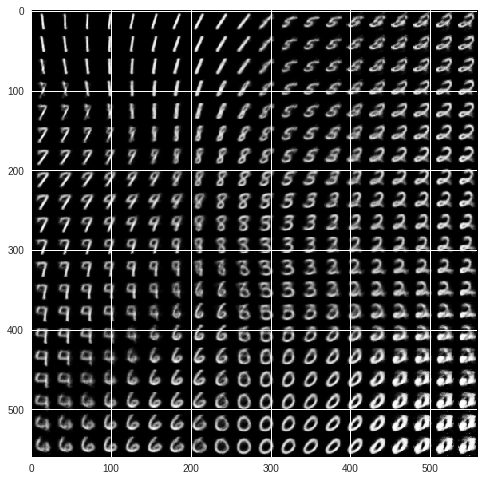

In [0]:
# Test

noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])

decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)


n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
        x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




1. I chose to work with Tensorflow's Variational Auto-Encoder.
The example I used is a Random Noise Image distorter.
I tweaked the number of steps a bit and got a wide variation of image distortions, I ran it back to back a couple of times, with the same numbers, and found that the amount of distorted image was similar, just in random spots according to the noise. I really want to take this out of colab, and run it on my machine to see what the improvement in time run may turn out to be.

2. The most changellenging part was dealing with the Complexities of Tensorflow, and trying to figure out how things worked to get different results.

3. This would probably be when I was researching the ds libraries, and Data sets, The resources that are available is staggering.

4. I would like to explore more with Computer Vision, and object identification, and tracking.

This is Me Randomly talking


**I am interested in The TensorFlow Library**

I was reading about the Google Coral accelerator the other day, and it got me looking into Tensor Flow.

The example I ended up on, uses random noise to distort a picture. 
I am changing the paramaters and changing how the noise distorts the picture.
The most difficult part is going through the steps for training TF.

I am definatly learning, that if I want to deal with Tensors, I need accelerators that can work with them a lot faster than I am doing now.

(I have a dataset that I really want to work on, unfortunatly I haven't gathered it yet.)
(I am also learning that I need to test if this will run faster on my system than Google CoLab)





## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.